# Desafio #QuarentenaDados

Bem-vinda e bem-vindo ao desafio #QuarentenaDados valendo um **Nintendo Switch**!

Esse notebook traz informações dos dados e como você deve configurar seu arquivo final para submissão.

**Caso queira usar esse notebook como exemplo para desenvolver seu projeto, clique em file e escolha a opção Save a copy in Drive**


Vamos trabalhar com uma amostra aleatória da base de dados MICRODADOS ENEM 2018, essa amostra é **diferente da apresentada em aula**. Junto com a divulgação do resultado final estaremos disponibilizando o código que gerou os dados para que você possa analisar e reproduzir os datasets. 

Seu objetivo é prever da melhor forma possível a nota das provas de **linguagens e códigos** (NU_NOTA_LC), dado todas as outras notas. O modelo que tiver o menor **erro quadrático médio (MSE)** vence o desafio.

Para o desafio você tem três bases à disposição, duas para desenvolver seu modelo e uma para submissão da predição. As bases são as seguintes:

- **dados_treino**: São 1500000 linhas contendo a nota das 4 provas + nota de redação.

- **dados_teste**: São 20000 linhas contendo com notas das 4 provas + nota de redação.

- **dados_desafioqt**: São 10000 linhas com nota de 3 provas + nota de redação. A nota da prova de **Linguagem e Codigos** (NU_NOTA_LC) não está disponível nessa base.


As base **dados_treino e dados_teste**, contém as seguintes colunas; **NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_MT, NU_NOTA_REDACAO, NU_NOTA_LC** (Você pode consultar a aula 5, onde o Guilherme explica o significado das siglas). A coluna que você deve realizar a **previsão** é **NU_NOTA_LC**. Você pode manipular os dados da forma que quiser, o importante é que no final submeta o arquivo com as informações corretas (detalhes da submissão serão discutidos no final deste notebook).

A base **dados_desafioqt**, contém as seguintes colunas; **ID, NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_MT, NU_NOTA_REDACAO**. Repare que os dados **NU_NOTA_LC** não estão presentes, essa é justamente a informação que você precisa prever. Nós temos os valores reais das notas, no final do prazo de submissão um script irá avaliar sua previsão e dará uma nota para o seu modelo. Nessa base também temos o **ID**, essa informação é importante para o envio da sua previsão, garanta que a nota prevista corresponda ao respectivo **ID**.

Se você está habituado com o desenvolvimento de modelos de ML, repare que essa divisão de dados é exatamente a mesma que Treino, Teste e Validação. 

Abaixo preparamos um código exemplo para você seguir, sinta-se à vontade para experimentar diversos outros métodos, mas **GARANTA QUE O ARQUIVO DE SUBMISSÃO ESTEJA CONFIGURADO CORRETAMENTE**.

Na primeira parte, estamos lendo a base de dados direto de arquivos no github.






In [0]:
import pandas as pd

URI_TREINO = "https://github.com/tgcsantos/quaretenadados/blob/master/DADOS_TREINO.csv?raw=true"
URI_TESTE = "https://github.com/tgcsantos/quaretenadados/raw/master/DADOS_TESTE.csv"
URI_DESAFIOQT = "https://github.com/tgcsantos/quaretenadados/raw/master/DESAFIOQT.csv"

dados_treino = pd.read_csv(URI_TREINO)
dados_teste = pd.read_csv(URI_TESTE)
dados_desafioqt = pd.read_csv(URI_DESAFIOQT)

erro_treino = "Erro ao carregar dados de treino"
erro_teste = "Erro ao carregar dados de teste"
erro_desafioqt = "Erro ao carregar dados de submissão"

assert dados_treino.shape == (150000, 5), erro_treino
assert dados_teste.shape == (20000, 5), erro_teste
assert dados_desafioqt.shape == (10000, 5), erro_desafioqt

In [2]:
dados_treino.isna().sum()

NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_LC         0
NU_NOTA_MT         0
NU_NOTA_REDACAO    0
dtype: int64

In [3]:
dados_teste.isna().sum()

NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_LC         0
NU_NOTA_MT         0
NU_NOTA_REDACAO    0
dtype: int64

In [4]:
dados_desafioqt.isna().sum()

ID                 0
NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_MT         0
NU_NOTA_REDACAO    0
dtype: int64

Agora com as bases de dados lidas, vamos separar as informações de cada dataset. X_treino e Y_treino são as **features**, X_teste e Y_teste são as **labels** a serem previstas.

Duas observações nesta parte:

- 1° Como já disponibilizamos os dados de treino e teste separados, você não precisa fazer *train_test_split* feito em aula (porém fique à vontade para trabalhar da forma que achar melhor).

- 2° Transformamos X_treino, Y_treino, X_teste, Y_teste em arrays numpy. Se você quiser usar uma biblioteca que não aceite dataframe como entrada de dados, já deixamos pronto para você.

In [0]:
dados = pd.concat([dados_treino,dados_teste])

In [6]:
dados.shape

(170000, 5)

In [7]:
dados.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000
mean,493.936284,570.806641,528.463731,535.492982,516.260706
std,74.090309,79.288819,72.368798,102.937438,184.427359
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,435.900000,513.500000,477.900000,455.400000,360.000000
50%,483.700000,584.900000,533.400000,516.700000,520.000000
75%,542.500000,629.700000,581.300000,600.800000,640.000000
max,869.600000,840.900000,787.400000,996.100000,1000.000000


In [0]:
dados = dados.drop((dados[(dados['NU_NOTA_CN'] == 0) & 
                    (dados['NU_NOTA_CH'] == 0) &
                    (dados['NU_NOTA_LC'] == 0) &
                    (dados['NU_NOTA_MT'] == 0) &
                    (dados['NU_NOTA_REDACAO'] == 0)]).index)

In [9]:
cn_count_zero = dados['NU_NOTA_CN'][dados['NU_NOTA_CN'] == 0].count()
cn_mean = dados['NU_NOTA_CN'][dados['NU_NOTA_CN'] != 0].mean()
cn_mediana = dados['NU_NOTA_CN'][dados['NU_NOTA_CN'] != 0].median()
print('Zeros:{0}\nMedia:{1}\nMediana:{2}'.format(cn_count_zero, cn_mean, cn_mediana))

Zeros:18
Media:493.99149493177913
Mediana:483.7


In [10]:
ch_count_zero = dados['NU_NOTA_CH'][dados['NU_NOTA_CH'] == 0].count()
ch_mean = dados['NU_NOTA_CH'][dados['NU_NOTA_CH'] != 0].mean()
ch_mediana = dados['NU_NOTA_CH'][dados['NU_NOTA_CH'] != 0].median()
print('Zeros:{0}\nMedia:{1}\nMediana:{2}'.format(ch_count_zero, ch_mean, ch_mediana))

Zeros:175
Media:571.3982063783768
Mediana:585.0


In [0]:
# lc_count_zero = dados['NU_NOTA_LC'][dados['NU_NOTA_LC'] == 0].count()
# lc_mean = dados['NU_NOTA_LC'][dados['NU_NOTA_LC'] != 0].mean()
# lc_mediana = dados['NU_NOTA_LC'][dados['NU_NOTA_LC'] != 0].median()
# print('Zeros:{0}\nMedia:{1}\nMediana:{2}'.format(lc_count_zero, lc_mean, lc_mediana))

In [12]:
mt_count_zero = dados['NU_NOTA_MT'][dados['NU_NOTA_MT'] == 0].count()
mt_mean = dados['NU_NOTA_MT'][dados['NU_NOTA_MT'] != 0].mean()
mt_mediana = dados['NU_NOTA_MT'][dados['NU_NOTA_MT'] != 0].median()
print('Zeros:{0}\nMedia:{1}\nMediana:{2}'.format(mt_count_zero, mt_mean, mt_mediana))

Zeros:19
Media:535.555988939884
Mediana:516.7


In [13]:
red_count_zero = dados['NU_NOTA_REDACAO'][dados['NU_NOTA_REDACAO'] == 0].count()
red_mean = dados['NU_NOTA_REDACAO'][dados['NU_NOTA_REDACAO'] != 0].mean()
red_mediana = dados['NU_NOTA_REDACAO'][dados['NU_NOTA_REDACAO'] != 0].median()
print('Zeros:{0}\nMedia:{1}\nMediana:{2}'.format(red_count_zero, red_mean, red_mediana))

Zeros:3493
Media:527.0940386532617
Mediana:520.0


In [0]:
from sklearn.model_selection import train_test_split

coluna_label = 'NU_NOTA_LC'
coluna_features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

X = dados[coluna_features]
Y = dados[coluna_label]


X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)


# Imputando dados nos datasets de treino e teste

In [15]:
X_treino.loc[X_treino['NU_NOTA_CN'] == 0, 'NU_NOTA_CN'] = X_treino['NU_NOTA_CN'].mean()
X_treino.loc[X_treino['NU_NOTA_CH'] == 0, 'NU_NOTA_CH'] = X_treino['NU_NOTA_CH'].mean()
X_treino.loc[X_treino['NU_NOTA_MT'] == 0, 'NU_NOTA_MT'] = X_treino['NU_NOTA_MT'].mean()
#X_treino.loc[X_treino['NU_NOTA_REDACAO'] == 0, 'NU_NOTA_REDACAO'] = X_treino['NU_NOTA_REDACAO'].median()


X_teste.loc[X_teste['NU_NOTA_CN'] == 0, 'NU_NOTA_CN'] = X_teste['NU_NOTA_CN'].mean()
X_teste.loc[X_teste['NU_NOTA_CH'] == 0, 'NU_NOTA_CH'] = X_teste['NU_NOTA_CH'].mean()
X_teste.loc[X_teste['NU_NOTA_MT'] == 0, 'NU_NOTA_MT'] = X_teste['NU_NOTA_MT'].mean()
#X_teste.loc[X_teste['NU_NOTA_REDACAO'] == 0, 'NU_NOTA_REDACAO'] = X_teste['NU_NOTA_REDACAO'].median()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/li

In [16]:
X_teste.loc[X_teste['NU_NOTA_REDACAO'] == 0]

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO
65043,423.8,450.6,455.8,0.0
35084,451.0,415.5,512.8,0.0
1987,569.4,447.2,393.9,0.0
108217,398.4,402.5,417.7,0.0
4647,385.8,456.0,453.8,0.0
...,...,...,...,...
418,453.7,466.1,419.9,0.0
47822,385.0,564.0,438.4,0.0
53607,476.1,563.3,454.4,0.0
127432,574.0,588.6,404.6,0.0


In [0]:
# coluna_label = 'NU_NOTA_LC'
# coluna_features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

# X_treino = dados_treino[coluna_features].to_numpy()
# Y_treino = dados_treino[coluna_label].to_numpy()
# X_teste = dados_teste[coluna_features].to_numpy()
# Y_teste = dados_teste[coluna_label].to_numpy()


A seguir criamos um modelo **Dummy** como exemplo e realizamos a avaliação do modelo com o **mean_squared_error**. 

Você pode usar qualquer algoritmo ou biblioteca para criar seus modelos, mas garanta que fará a avaliação com o mean_squared_error, pois usaremos essa métrica para avaliar sua predição final.

In [17]:
#Exemplo de classificação com Dummy
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

modelo_dummy = DummyRegressor()
modelo_dummy.fit(X_treino, Y_treino)
dummy_predicoes = modelo_dummy.predict(X_teste)

avaliacao_dummy = mean_squared_error(Y_teste, dummy_predicoes)

print(f"Minha avaliação nos dados de teste foi de {avaliacao_dummy}")

Minha avaliação nos dados de teste foi de 5190.8636971852075


Depois que você criou testou e validou seu modelo, chegou a hora de preparar seu arquivo para a submissão do resultado.

No código abaixo, estamos realizando a predição das notas de **linguagem e códigos** do dataset **dados_desafioqt**. Feita a previsão, criamos um dataframe novo para a submissão, primeiro crimos a coluna **ID** e adicionamos a coluna **NU_NOTA_LC** com suas respectivas previsões (repare que nosso modelo não alterou as ordens dos ID's, mas se você utilizar algum modelo que embaralhe essa ordem certifique de colocar a previsão correta para o ID correto).

Após isso, salvamos o dataframe com ´.to_csv()´ (**importante, passe o parâmetro index=False para `.to_csv()`, caso contrário nosso script não computará sua nota**) no arquivo **PREDICAO_DESAFIOQT.csv (você precisa submeter o arquivo com esse nome, caso contrário nosso script de avaliação não computará sua nota**)  e utilizamos o `files.download` para baixar o arquivo em sua máquina local.

Feito tudo isso você está quase pronto para finalizar e submeter seu resultado. Você já baixou os dados, treinou e validou seu modelo, salvou sua previsão **no padrão ideal para submissão** e já está com o modelo baixado em sua máquina. Entretanto, ainda falta um detalhe: no momento de preencher o **forms** você precisa enviar seu código. Caso esteja usando os notebooks do colab siga as seguintes instruções para o download:

- Clique em **File** na parte superior esquerda.
- Depois selecione a opção **Download .ipynb** (também aceitaremos o .py caso você prefira desenvolver seu projeto em um arquivo python).


Pronto agora é só submeter seu resultado e torcer para levar um **Nintendo Switch** para casa.

Boa sorte!

In [0]:
#atribuir ao MODELO o nome do seu melhor modelo
from google.colab import files

MODELO = modelo_dummy
X_desafioqt = dados_desafioqt[coluna_features].to_numpy()
predicao_desafioqt = MODELO.predict(X_desafioqt)


desafio_df = pd.DataFrame(dados_desafioqt.ID)
desafio_df[coluna_label] = predicao_desafioqt

#NÃO TROCAR O NOME DO ARQUIVO DE SAÍDA (PREDICAO_DESAFIO)
desafio_df.to_csv('PREDICAO_DESAFIOQT.csv', index=False) 
files.download('PREDICAO_DESAFIOQT.csv')



In [19]:
dados_treino.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,530.7,586.5,575.9,539.0,520.0
1,439.4,577.9,440.9,488.7,380.0
2,414.1,548.8,417.2,382.6,600.0
3,407.9,572.7,558.9,595.4,560.0
4,617.2,655.7,564.2,660.9,540.0


In [20]:
dados_teste.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,468.6,579.2,550.0,605.0,540.0
1,463.5,442.6,406.3,413.8,440.0
2,593.3,717.3,652.3,693.6,980.0
3,426.0,603.6,469.1,455.2,380.0
4,537.8,601.6,580.5,502.0,620.0


In [21]:
dados_desafioqt.head()

,ID,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO
0,0,496.1,585.3,495.8,320.0
1,1,558.5,641.9,515.9,600.0
2,2,493.1,566.6,512.0,520.0
3,3,410.9,534.4,437.6,340.0
4,4,453.5,577.9,545.8,580.0


# Modelo 1 - Decision Tree

In [0]:
from sklearn.tree import DecisionTreeRegressor

modelo_decision_tree = DecisionTreeRegressor(random_state=1)

In [23]:
modelo_decision_tree.fit(X_treino, Y_treino)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [24]:
predicao_decision_tree = modelo_decision_tree.predict(X_teste)

avaliacao__decision_tree = mean_squared_error(Y_teste, predicao_decision_tree)

print(f"Avaliação nos dados de teste para o modelo de Árvore de decisão foi de {avaliacao__decision_tree}")

Avaliação nos dados de teste para o modelo de Árvore de decisão foi de 4242.919370588234


### Testando outros parâmetros para esse modelo

In [0]:
def get_mse(max_leaf_nodes, X_treino, X_teste, Y_treino, Y_teste):
  modelo_decision_tree = DecisionTreeRegressor(random_state=1, max_leaf_nodes=max_leaf_nodes)
  modelo_decision_tree.fit(X_treino, Y_treino)
  predicao_decision_tree = modelo_decision_tree.predict(X_teste)
  avaliacao__decision_tree = mean_squared_error(Y_teste, predicao_decision_tree)
  return avaliacao__decision_tree


In [26]:
get_mse(50, X_treino, X_teste, Y_treino, Y_teste)

2143.485977245864

Testando o modelo para diferentes quantidades de nós

In [27]:
for max_leaf_nodes in [5, 10, 25, 50, 100, 200, 500, 1000]:
  mse = get_mse(max_leaf_nodes, X_treino, X_teste, Y_treino, Y_teste)
  print('Quantidade de nós: {0}      MSE: {1}'.format(max_leaf_nodes, mse))

Quantidade de nós: 5      MSE: 2520.318293408387
Quantidade de nós: 10      MSE: 2322.52427568272
Quantidade de nós: 25      MSE: 2191.9540789281577
Quantidade de nós: 50      MSE: 2143.485977245864
Quantidade de nós: 100      MSE: 2119.3123703567994
Quantidade de nós: 200      MSE: 2104.6400396454455
Quantidade de nós: 500      MSE: 2128.5727739897743
Quantidade de nós: 1000      MSE: 2187.3146050236483


### Para o modelo de Arvore de decisão acima a melhor performance ocorreu com 200 nós

# Modelo 2 - Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

modelo_random_forest = RandomForestRegressor(random_state=1)

modelo_random_forest.fit(X_treino, Y_treino)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [29]:
predicao_random_forest = modelo_random_forest.predict(X_teste)

avaliacao_random_forest = mean_squared_error(Y_teste, predicao_random_forest)

print(f"Avaliação nos dados de teste para o modelo de Árvore de decisão foi de {avaliacao_random_forest}")

Avaliação nos dados de teste para o modelo de Árvore de decisão foi de 2180.957628821029


### Testando outros parametros

In [0]:
modelo_random_forest_1 = RandomForestRegressor(n_estimators=50, random_state=0)
modelo_random_forest_2 = RandomForestRegressor(n_estimators=100, random_state=0)
modelo_random_forest_3 = RandomForestRegressor(n_estimators=100, min_samples_split=20, random_state=0)
modelo_random_forest_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
modelo_random_forest_5 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
modelo_random_forest_6 = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=0)

modelos_rf = [modelo_random_forest_1, modelo_random_forest_2, modelo_random_forest_3, modelo_random_forest_4, modelo_random_forest_5, modelo_random_forest_6]

In [31]:
def avaliacao(modelo, X_treino, X_teste, Y_treino, Y_teste):
    modelo.fit(X_treino, Y_treino)
    predicoes = modelo.predict(X_teste)
    return mean_squared_error(Y_teste, predicoes)

for i in range(0, len(modelos_rf)):
    mse = avaliacao(modelos_rf[i], X_treino, X_teste, Y_treino, Y_teste)
    print("Modelo %d MSE: %d" % (i+1, mse))

Modelo 1 MSE: 2198
Modelo 2 MSE: 2178
Modelo 3 MSE: 2098
Modelo 4 MSE: 2092
Modelo 5 MSE: 2119
Modelo 6 MSE: 2119


# Validação cruzada

In [0]:
dados_cv = dados.copy()

X_cv = dados_cv[coluna_features]

Y_cv = dados_cv[coluna_label]

In [0]:
dados_cv.loc[dados_cv['NU_NOTA_CN'] == 0, 'NU_NOTA_CN'] = dados_cv['NU_NOTA_CN'].mean()
dados_cv.loc[dados_cv['NU_NOTA_CH'] == 0, 'NU_NOTA_CH'] = dados_cv['NU_NOTA_CH'].mean()
dados_cv.loc[dados_cv['NU_NOTA_MT'] == 0, 'NU_NOTA_MT'] = dados_cv['NU_NOTA_MT'].mean()

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
def avaliacao_cv(n_estimators):
  modelo_cv = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=20, max_depth=8, n_jobs=-1, random_state=0)

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [0]:
n_trees = [100, 200, 400, 500]
avaliacoes={}
for i in n_trees:
    avaliacoes[i] = avaliacao_cv(i)

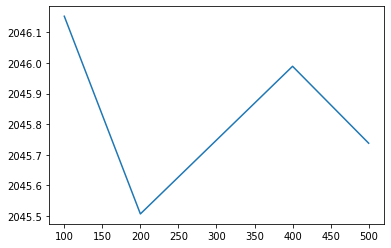

In [37]:
import matplotlib.pyplot as plt

plt.plot(list(avaliacoes.keys()), list(avaliacoes.values()))
plt.show()

# Modelo 3 - Gradient Boosting

In [38]:
from xgboost import XGBRegressor

modelo_xg = XGBRegressor(random_state=0, objective='reg:squarederror')
modelo_xg.fit(X_treino, Y_treino)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [39]:
predicoes_xg = modelo_xg.predict(X_teste)
print("MSE: " + str(mean_squared_error(predicoes_xg, Y_teste)))

MSE: 2029.2639012767559


In [40]:
modelo_xg_1 = XGBRegressor(n_estimators=500, random_state=0, objective='reg:squarederror')
modelo_xg_1.fit(X_treino, Y_treino)
predicoes_xg_1 = modelo_xg_1.predict(X_teste)
print("MSE: " + str(mean_squared_error(predicoes_xg_1, Y_teste)))

MSE: 2033.3115710828965


In [0]:
def avaliacao_xg(n_estimators):
  modelo = XGBRegressor(n_estimators=n_estimators, random_state=0, objective='reg:squarederror')
  modelo.fit(X_treino, Y_treino)
  predicoes = modelo.predict(X_teste)
  return(mean_squared_error(predicoes, Y_teste))

In [42]:
estimators = [50, 100, 150, 200, 250, 300]

for i in estimators:
  mse = avaliacao_xg(i)
  print('Estimators: {0}      MSE:{1}'.format(i, mse))

Estimators: 50      MSE:2040.1739972958433
Estimators: 100      MSE:2029.2639012767559
Estimators: 150      MSE:2029.5484671439256
Estimators: 200      MSE:2029.8029384372326
Estimators: 250      MSE:2030.0652502177647
Estimators: 300      MSE:2030.6399704479584


In [43]:
modelo_xg_2 = XGBRegressor(n_estimators=200, random_state=0, objective='reg:squarederror')
modelo_xg_2.fit(X_treino, Y_treino, 
                early_stopping_rounds=5,
                eval_set=[(X_teste, Y_teste)],
                verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [44]:
predicoes_xg_2 = modelo_xg_2.predict(X_teste)
print("MSE: " + str(mean_squared_error(predicoes_xg_2, Y_teste)))

MSE: 2029.1897560586206


In [45]:
modelo_xg_3 = XGBRegressor(n_estimators=900, learning_rate=0.02, random_state=0, objective='reg:squarederror', max_depth=5)
modelo_xg_3.fit(X_treino, Y_treino, 
                early_stopping_rounds=5,
                eval_set=[(X_teste, Y_teste)],
                verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=900,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [46]:
predicoes_xg_3 = modelo_xg_3.predict(X_teste)
print("MSE: " + str(mean_squared_error(predicoes_xg_3, Y_teste)))

MSE: 2025.9923914122073


In [0]:
def avaliacao_cv_xg(n_estimators):
  modelo_cv = XGBRegressor(n_estimators=n_estimators, learning_rate=0.05, random_state=0, objective='reg:squarederror')

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [0]:
n_trees = [100, 200, 300, 400]
avaliacoes_xg={}
for i in n_trees:
    avaliacoes_xg[i] = avaliacao_cv_xg(i)

In [49]:
avaliacoes_xg

{100: 2038.19788352073,
 200: 2022.512112204881,
 300: 2021.6458459174864,
 400: 2022.9697583774341}

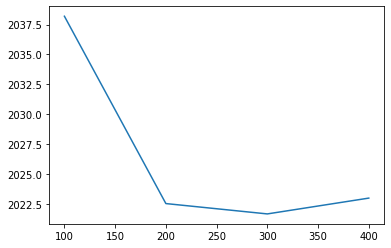

In [50]:
plt.plot(list(avaliacoes_xg.keys()), list(avaliacoes_xg.values()))
plt.show()

In [0]:
def avaliacao_cv_xg_2(n_estimators):
  modelo_cv = XGBRegressor(n_estimators=n_estimators, learning_rate=0.02, random_state=0, objective='reg:squarederror')

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [0]:
n_trees_2 = [900, 910, 920, 930]

avaliacoes_xg_2={}
for i in n_trees_2:
    avaliacoes_xg_2[i] = avaliacao_cv_xg_2(i)

In [53]:
avaliacoes_xg_2

{900: 2020.6849994674044,
 910: 2020.6938439300532,
 920: 2020.6532709217304,
 930: 2020.7187483475602}

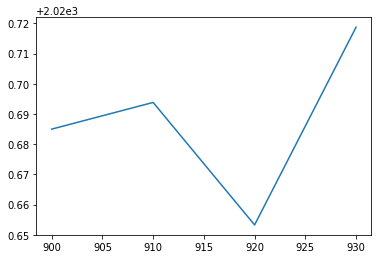

In [54]:
plt.plot(list(avaliacoes_xg_2.keys()), list(avaliacoes_xg_2.values()))
plt.show()

In [0]:
def avaliacao_cv_xg_3(n_estimators):
  modelo_cv = XGBRegressor(n_estimators=n_estimators, 
                           learning_rate=0.02,
                           random_state=0, 
                           objective='reg:squarederror',
                           max_depth=3, 
                           n_jobs=-1)

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [56]:
avaliacao_cv_xg_3(900)

2020.6849994674044

# Testando os diferentes tipos de hiperparâmetros do XGBoost

### Teste 1 : max_depth e min_child_weight

In [0]:
def avaliacao_cv_xg_3(max_depth, min_child_weight):
  modelo_cv = XGBRegressor(n_estimators=900, 
                           learning_rate=0.02,
                           random_state=0, 
                           objective='reg:squarederror',
                           max_depth=max_depth, 
                           min_child_weight=min_child_weight, 
                           n_jobs=-1)

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [58]:
max_depth_list = [3, 5, 7]
min_child_weight_list = [1, 3, 5]

for i in max_depth_list:
  for j in min_child_weight_list:
    mse = avaliacao_cv_xg_3(i,j)

    print("max_depth:{0}    min_child_weight:{1}    mse:{2}".format(i,j,mse))

max_depth:3    min_child_weight:1    mse:2020.6849994674044
max_depth:3    min_child_weight:3    mse:2021.2811608670868
max_depth:3    min_child_weight:5    mse:2020.7017559196204
max_depth:5    min_child_weight:1    mse:2028.9693417617611
max_depth:5    min_child_weight:3    mse:2027.9222604300571
max_depth:5    min_child_weight:5    mse:2027.6411683360773
max_depth:7    min_child_weight:1    mse:2039.3076907434424
max_depth:7    min_child_weight:3    mse:2039.0672731476413
max_depth:7    min_child_weight:5    mse:2036.7702005372382


Melhores valores encontrados: 
max_depth:3    min_child_weight:1    mse:2020.6849994674044

### Teste 1.2 : Testando min_child_weight para valores maiores

In [59]:
max_depth_list = [3]
min_child_weight_list = [7, 8, 9]

for i in max_depth_list:
  for j in min_child_weight_list:
    mse = avaliacao_cv_xg_3(i,j)

    print("max_depth:{0}    min_child_weight:{1}    mse:{2}".format(i,j,mse))

max_depth:3    min_child_weight:7    mse:2020.494242496138
max_depth:3    min_child_weight:8    mse:2020.6203871444552
max_depth:3    min_child_weight:9    mse:2020.219332536669


Melhores valores encontrados: max_depth:3    min_child_weight:9    mse:2020.219332536669


### Teste 2 : colsample_bytree e subsample



In [0]:
def avaliacao_cv_xg_4(colsample_bytree, subsample):

  modelo_cv = XGBRegressor(n_estimators=900, 
                           learning_rate=0.02,
                           random_state=0, 
                           objective='reg:squarederror',
                           max_depth=3, 
                           min_child_weight=9,
                           colsample_bytree=colsample_bytree,
                           subsample=subsample, 
                           n_jobs=-1)

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [61]:
subsample=[0.6, 0.7, 0.8, 0.9]
colsample_bytree=[0.6, 0.7, 0.8, 0.9]

for i in subsample:
  for j in colsample_bytree:
    mse = avaliacao_cv_xg_4(i,j)

    print("subsample:{0}    colsample_bytree:{1}    mse:{2}".format(i,j,mse))

subsample:0.6    colsample_bytree:0.6    mse:2019.946338945995
subsample:0.6    colsample_bytree:0.7    mse:2020.3712714911453
subsample:0.6    colsample_bytree:0.8    mse:2020.3614685367982
subsample:0.6    colsample_bytree:0.9    mse:2020.6734185094588
subsample:0.7    colsample_bytree:0.6    mse:2019.946338945995
subsample:0.7    colsample_bytree:0.7    mse:2020.3712714911453
subsample:0.7    colsample_bytree:0.8    mse:2020.3614685367982
subsample:0.7    colsample_bytree:0.9    mse:2020.6734185094588
subsample:0.8    colsample_bytree:0.6    mse:2022.637422638621
subsample:0.8    colsample_bytree:0.7    mse:2023.0690529166957
subsample:0.8    colsample_bytree:0.8    mse:2022.7860683914332
subsample:0.8    colsample_bytree:0.9    mse:2022.6071116247458
subsample:0.9    colsample_bytree:0.6    mse:2022.637422638621
subsample:0.9    colsample_bytree:0.7    mse:2023.0690529166957
subsample:0.9    colsample_bytree:0.8    mse:2022.7860683914332
subsample:0.9    colsample_bytree:0.9    mse

Melhores valores encontrados: subsample:0.6    colsample_bytree:0.6    mse:2019.946338945995

### Teste 3 : Alpha  - L1 Regularization

In [0]:
def avaliacao_cv_xg_alpha(reg_alpha):

  modelo_cv = XGBRegressor(n_estimators=900, 
                           learning_rate=0.02,
                           random_state=0, 
                           objective='reg:squarederror',
                           max_depth=3, 
                           min_child_weight=9,
                           colsample_bytree=0.6,
                           subsample=0.6, 
                           reg_alpha=reg_alpha,
                           n_jobs=-1)

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [63]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]

for i in reg_alpha:
  mse = avaliacao_cv_xg_alpha(i)

  print("avaliacao_cv_xg_alpha:{0}    mse:{1}".format(i,mse))

avaliacao_cv_xg_alpha:1e-05    mse:2019.9463390969206
avaliacao_cv_xg_alpha:0.01    mse:2019.8840813773245
avaliacao_cv_xg_alpha:0.1    mse:2019.9369285957473
avaliacao_cv_xg_alpha:1    mse:2020.038200065987
avaliacao_cv_xg_alpha:100    mse:2019.4449421203408


### Teste 3.1 : Refinando Alpha

In [64]:
reg_alpha = [100, 200, 300]

for i in reg_alpha:
  mse = avaliacao_cv_xg_alpha(i)

  print("avaliacao_cv_xg_alpha:{0}    mse:{1}".format(i,mse))

avaliacao_cv_xg_alpha:100    mse:2019.4449421203408
avaliacao_cv_xg_alpha:200    mse:2019.1555812127524
avaliacao_cv_xg_alpha:300    mse:2018.942770244987


In [65]:
avaliacao_cv_xg_alpha(1000)

2017.5893782544827

In [68]:
reg_alpha = [0.05, 0.2, 0.5, 700, 800, 900]

for i in reg_alpha:
  mse = avaliacao_cv_xg_alpha(i)

  print("avaliacao_cv_xg_alpha:{0}    mse:{1}".format(i,mse))

avaliacao_cv_xg_alpha:0.05    mse:2020.004949144473
avaliacao_cv_xg_alpha:0.2    mse:2019.989863779359
avaliacao_cv_xg_alpha:0.5    mse:2019.9971490479807
avaliacao_cv_xg_alpha:700    mse:2017.8186706592587
avaliacao_cv_xg_alpha:800    mse:2017.7714324275562
avaliacao_cv_xg_alpha:900    mse:2017.8839302253969


### Teste 4: Lambda - L2 Regularization

In [0]:
def avaliacao_cv_xg_lambda(reg_alpha, reg_lambda):

  modelo_cv = XGBRegressor(n_estimators=900, 
                           learning_rate=0.02,
                           random_state=0, 
                           objective='reg:squarederror',
                           max_depth=3, 
                           min_child_weight=9,
                           colsample_bytree=0.6,
                           subsample=0.6, 
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           n_jobs=-1)

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [70]:
reg_alpha=[0.01, 100, 1000]
reg_lambda=[1e-5, 1e-2, 0.1, 1, 100]

for i in reg_alpha:
  for j in reg_lambda:
    mse = avaliacao_cv_xg_lambda(i,j)

    print("alpha:{0}    lambda:{1}    mse:{2}".format(i,j,mse))

alpha:0.01    lambda:1e-05    mse:2020.0940559686562
alpha:0.01    lambda:0.01    mse:2020.2476493089591
alpha:0.01    lambda:0.1    mse:2020.2966908900792
alpha:0.01    lambda:1    mse:2019.8840813773245
alpha:0.01    lambda:100    mse:2020.4668022294368
alpha:100    lambda:1e-05    mse:2019.4125559007284
alpha:100    lambda:0.01    mse:2019.4077610875847
alpha:100    lambda:0.1    mse:2019.3456400102416
alpha:100    lambda:1    mse:2019.4449421203408
alpha:100    lambda:100    mse:2020.2571629774743
alpha:1000    lambda:1e-05    mse:2017.8050231365294
alpha:1000    lambda:0.01    mse:2017.8315947457384
alpha:1000    lambda:0.1    mse:2017.782817164799
alpha:1000    lambda:1    mse:2017.5893782544827
alpha:1000    lambda:100    mse:2019.7714590746145


In [71]:
reg_alpha=[1000]
reg_lambda=[0.5, 1, 2, 3]

for i in reg_alpha:
  for j in reg_lambda:
    mse = avaliacao_cv_xg_lambda(i,j)

    print("alpha:{0}    lambda:{1}    mse:{2}".format(i,j,mse))

alpha:1000    lambda:0.5    mse:2017.9314366707054
alpha:1000    lambda:1    mse:2017.5893782544827
alpha:1000    lambda:2    mse:2017.8282079375772
alpha:1000    lambda:3    mse:2017.9097118149002


# Teste 5: Learing rate

In [0]:
def avaliacao_cv_xg_lr(learning_rate):

  modelo_cv = XGBRegressor(n_estimators=900, 
                           learning_rate=learning_rate,
                           random_state=0, 
                           objective='reg:squarederror',
                           max_depth=3, 
                           min_child_weight=9,
                           colsample_bytree=0.6,
                           subsample=0.6, 
                           reg_alpha=1000,
                           reg_lambda=1,
                           n_jobs=-1)

  scores = -1 * cross_val_score(modelo_cv, X_cv, Y_cv,
                              cv=5,
                              scoring='neg_mean_squared_error')
  return scores.mean()

In [80]:
learning_rate = [0.025, 0.035]

for i in learning_rate:
  mse = avaliacao_cv_xg_lr(i)

  print("learning_rate:{0}    mse:{1}".format(i,mse))

learning_rate:0.025    mse:2017.5863453436305
learning_rate:0.035    mse:2017.2547838776015


In [82]:
learning_rate = [0.03]

for i in learning_rate:
  mse = avaliacao_cv_xg_lr(i)

  print("learning_rate:{0}    mse:{1}".format(i,mse))

learning_rate:0.03    mse:2017.0766943411443


In [0]:
modelo_final = XGBRegressor(n_estimators=900, 
                          learning_rate=0.03,
                          random_state=0, 
                          objective='reg:squarederror',
                          max_depth=3, 
                          min_child_weight=9,
                          colsample_bytree=0.6,
                          subsample=0.6, 
                          reg_alpha=1000,
                          reg_lambda=1,
                          n_jobs=-1)

In [98]:
modelo_final.fit(X_cv, Y_cv)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=3, min_child_weight=9, missing=None, n_estimators=900,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1000, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.6, verbosity=1)

# Tratando o Dataset final

In [93]:
dados_desafioqt.describe()

,ID,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,493.699120,571.692870,535.307860,515.546000
std,2886.89568,73.512058,78.388181,103.141515,183.814419
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,2499.75000,436.100000,515.400000,455.100000,360.000000
50%,4999.50000,483.650000,586.300000,517.550000,520.000000
75%,7499.25000,542.700000,630.400000,601.000000,620.000000
max,9999.00000,771.100000,776.700000,946.500000,980.000000


In [0]:
dados_desafioqt.loc[dados_desafioqt['NU_NOTA_CN'] == 0, 'NU_NOTA_CN'] = dados_desafioqt['NU_NOTA_CN'].mean()
dados_desafioqt.loc[dados_desafioqt['NU_NOTA_CH'] == 0, 'NU_NOTA_CH'] = dados_desafioqt['NU_NOTA_CH'].mean()
dados_desafioqt.loc[dados_desafioqt['NU_NOTA_MT'] == 0, 'NU_NOTA_MT'] = dados_desafioqt['NU_NOTA_MT'].mean()

In [95]:
dados_desafioqt.describe()

,ID,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,493.797860,572.207394,535.468452,515.546000
std,2886.89568,73.179644,76.487014,102.723763,183.814419
min,0.00000,362.500000,394.500000,369.400000,0.000000
25%,2499.75000,436.100000,515.775000,455.200000,360.000000
50%,4999.50000,483.700000,586.300000,517.650000,520.000000
75%,7499.25000,542.700000,630.400000,601.000000,620.000000
max,9999.00000,771.100000,776.700000,946.500000,980.000000


In [0]:
from google.colab import files


X_desafioqt = dados_desafioqt[coluna_features]
predicao_desafioqt = modelo_final.predict(X_desafioqt)


desafio_df = pd.DataFrame(dados_desafioqt.ID)
desafio_df[coluna_label] = predicao_desafioqt

#NÃO TROCAR O NOME DO ARQUIVO DE SAÍDA (PREDICAO_DESAFIO)
desafio_df.to_csv('PREDICAO_DESAFIOQT.csv', index=False) 
files.download('PREDICAO_DESAFIOQT.csv')